# Supplemental Figure 2 - showing basic statistics of syllables

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "supp-fig2", tight_layout=False)

In [3]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_syllable_df_v00.parquet')

In [4]:
durs = []

fps = 30
for uuid, _df in tqdm(df.groupby('uuid', sort=False)):
    onset_idx = np.where(_df['onsets'])[0]
    _durs = np.diff(onset_idx) / fps
    durs.extend(_durs)
durs = np.array(durs, dtype='float32')

  0%|          | 0/363 [00:00<?, ?it/s]

In [11]:
dur_sd = round(np.std(durs) * 1000)

webf NOT subset; don't know how to subset; dropped


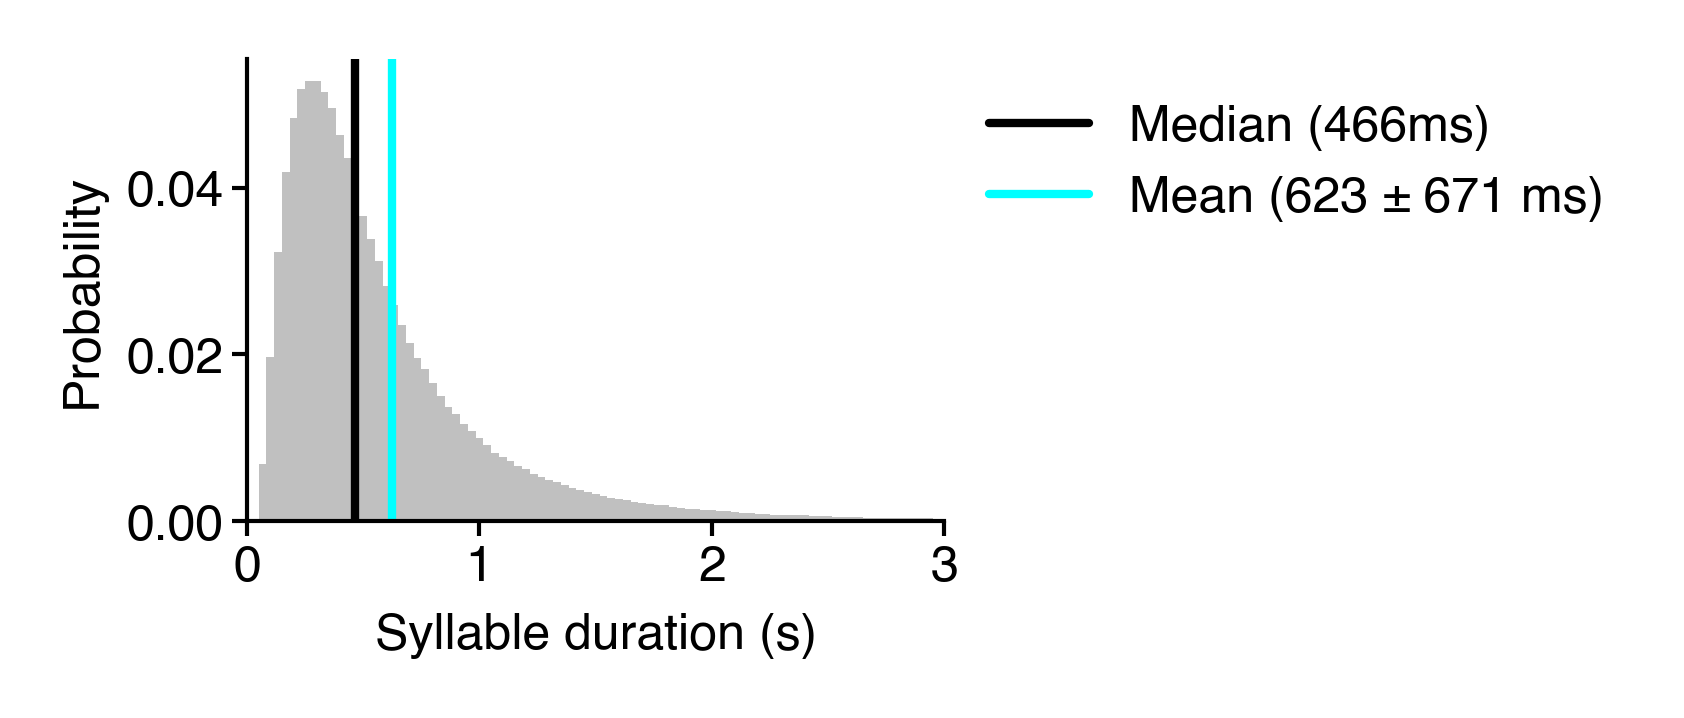

In [14]:
fig = figure(1.5, 1)
ax = sns.histplot(
    durs,
    bins=(np.arange(fps * 3) / fps) + (1 / (fps * 2)),
    element="step",
    fill=True,
    lw=0,
    stat="probability",
    color="silver",
    alpha=1,
)
ax.set(xlabel="Syllable duration (s)", xlim=(0, 3))
ax.axvline(
    np.median(durs), color="k", label=f"Median ({int(np.median(durs) * 1000)}ms)"
)
ax.axvline(np.mean(durs), color="cyan", label=f"Mean ({int(np.mean(durs) * 1000)} ± {dur_sd} ms)")
legend()
sns.despine()
saver(fig, "global-syllable-duration-ontogeny-males");

## Syllable counts over all the data

In [3]:
usage_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_counts_matrix_v00.parquet')
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
usage_df = usage_df[keep_syllables]

In [42]:
usage_df.melt()

,syllables,value
0,0,4.0
1,0,10.0
2,0,11.0
3,0,4.0
4,0,6.0
...,...,...
20875,98,30.0
20876,98,48.0
20877,98,21.0
20878,98,102.0


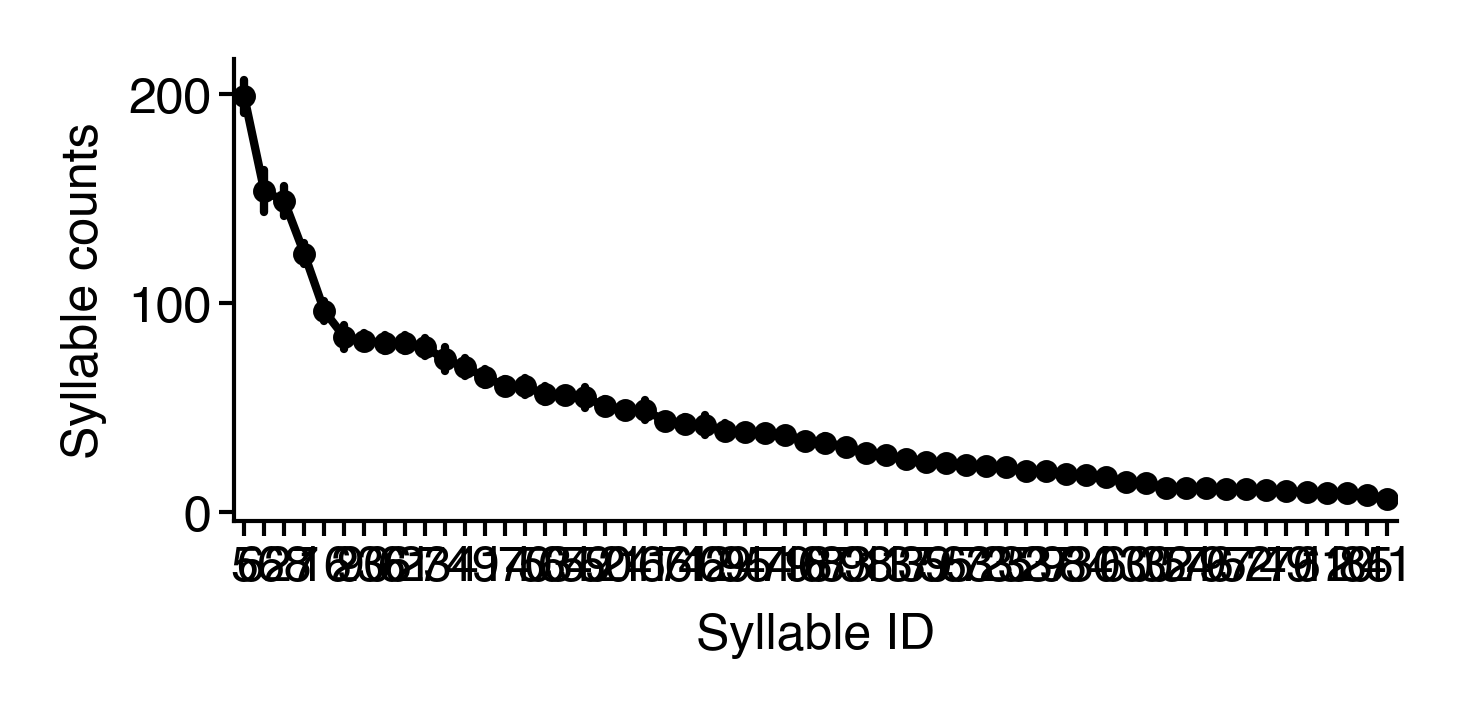

In [60]:
order = usage_df.mean().sort_values(ascending=False).index

fig = figure(2.5, 1)
ax = sns.pointplot(data=usage_df.melt(), x='syllables', y='value', errorbar=('se', 2), order=order, color="k", markersize=2, linewidth=1, err_kws=dict(linewidth=1))
sns.despine()
ax.set(ylabel="Syllable counts", xlabel="Syllable ID")
saver(fig, "global-syllable-usage-counts");

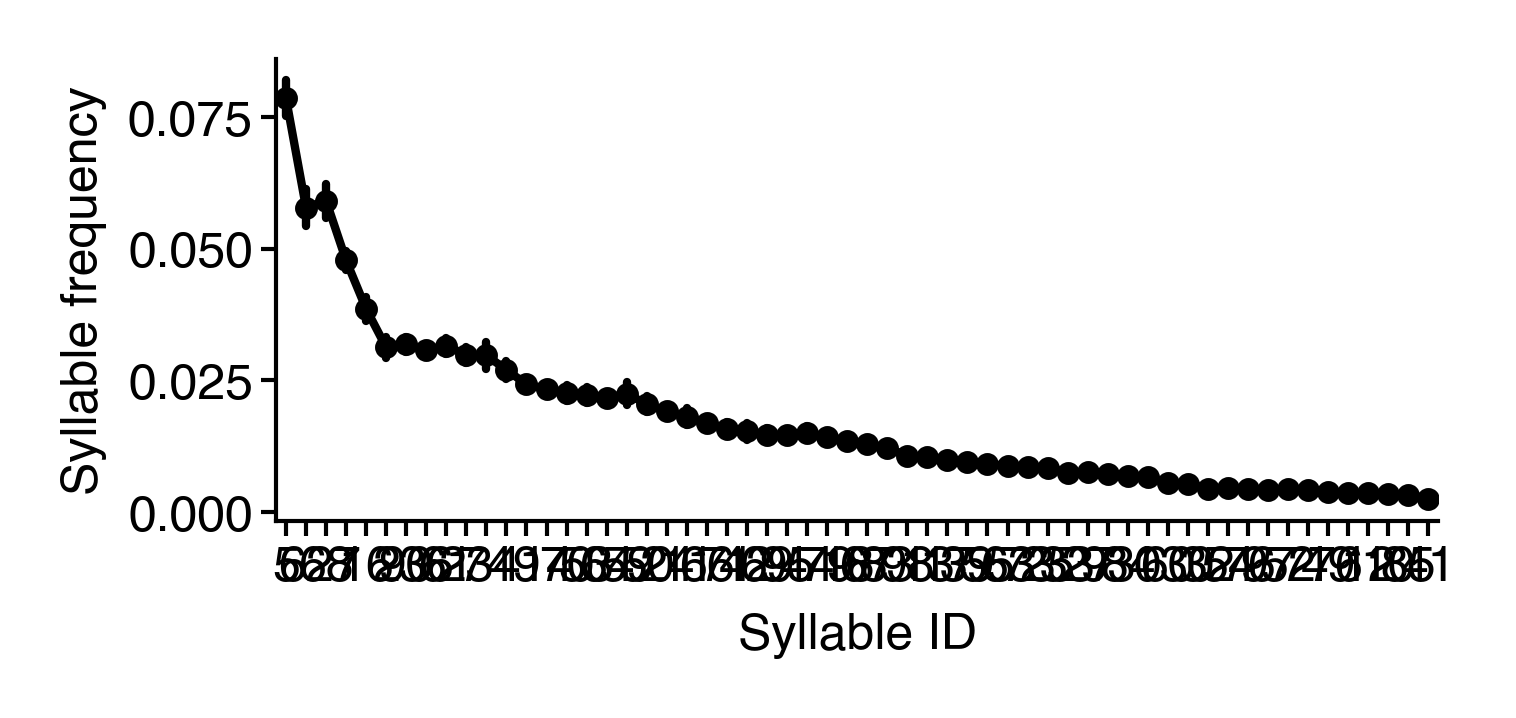

In [58]:
order = usage_df.mean().sort_values(ascending=False).index

fig = figure(2.5, 1)
ax = sns.pointplot(data=(usage_df / usage_df.sum(1).to_numpy()[:, None]).melt(), x='syllables', y='value', errorbar=('se', 2), order=order, color="k", markersize=2, linewidth=1, err_kws=dict(linewidth=1))
sns.despine()
ax.set(ylabel="Syllable frequency", xlabel="Syllable ID")
saver(fig, "global-syllable-usage-frequencies");

## Compute transition matrix

In [64]:
from toolz import sliding_window

In [62]:
def compute_tm(df, max_syllable=100):
    tm = np.zeros((max_syllable, ) * 2)
    for _in, _out in sliding_window(2, df['syllables']):
        tm[_in, _out] += 1
    return tm

In [78]:
tm = [compute_tm(_df) for uuid, _df in tqdm(df.query('onsets').groupby('uuid', sort=False))]
tm = np.mean(tm, axis=0)
tm = tm[keep_syllables][:, keep_syllables]

  0%|          | 0/363 [00:00<?, ?it/s]

In [79]:
usage_sort = np.argsort(tm.sum(1))[::-1]

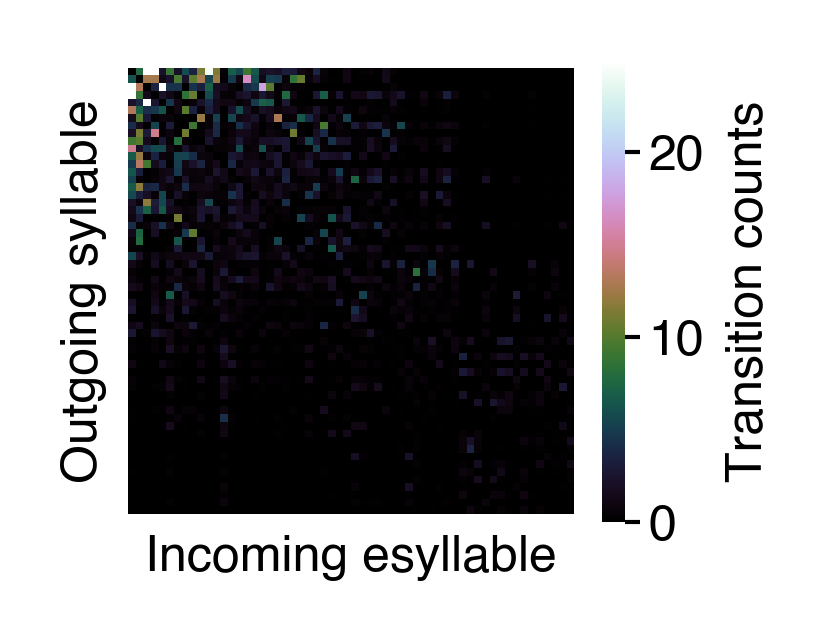

In [94]:
fig = figure(1.2, 1)
ax = sns.heatmap(
    tm[usage_sort][:, usage_sort],
    vmax=25,
    cbar_kws=dict(label="Transition counts"),
    cmap="cubehelix",
)
ax.set(
    aspect="equal",
    xticks=[],
    yticks=[],
    xlabel="Incoming esyllable",
    ylabel="Outgoing syllable",
)
saver(fig, "total-transition-matrix");

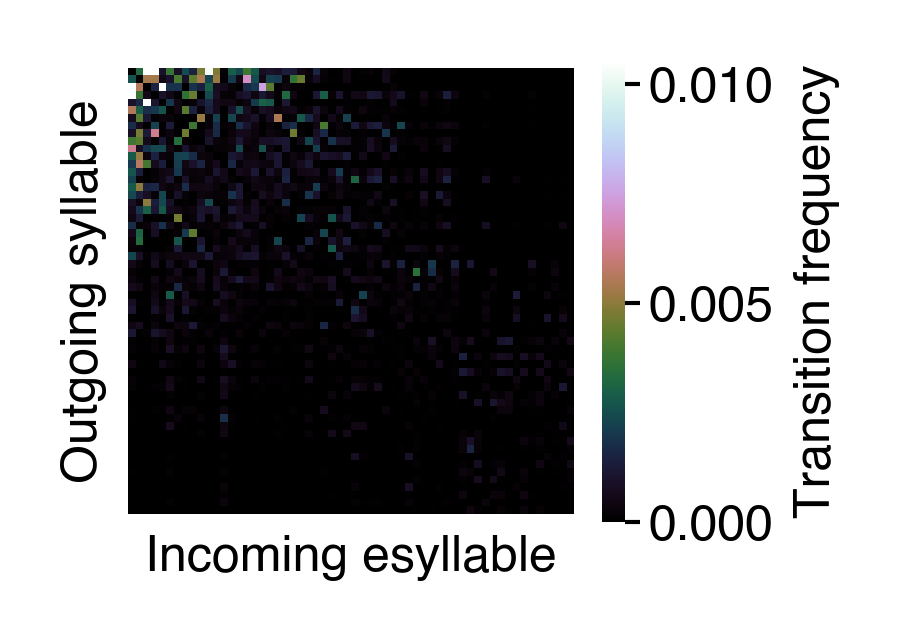

In [96]:
fig = figure(1.2, 1)
ax = sns.heatmap(
    tm[usage_sort][:, usage_sort] / tm.sum(),
    vmax=25 / tm.sum(),
    cbar_kws=dict(label="Transition frequency"),
    cmap="cubehelix",
)
ax.set(
    aspect="equal",
    xticks=[],
    yticks=[],
    xlabel="Incoming esyllable",
    ylabel="Outgoing syllable",
)
saver(fig, "total-transition-matrix-frequency");

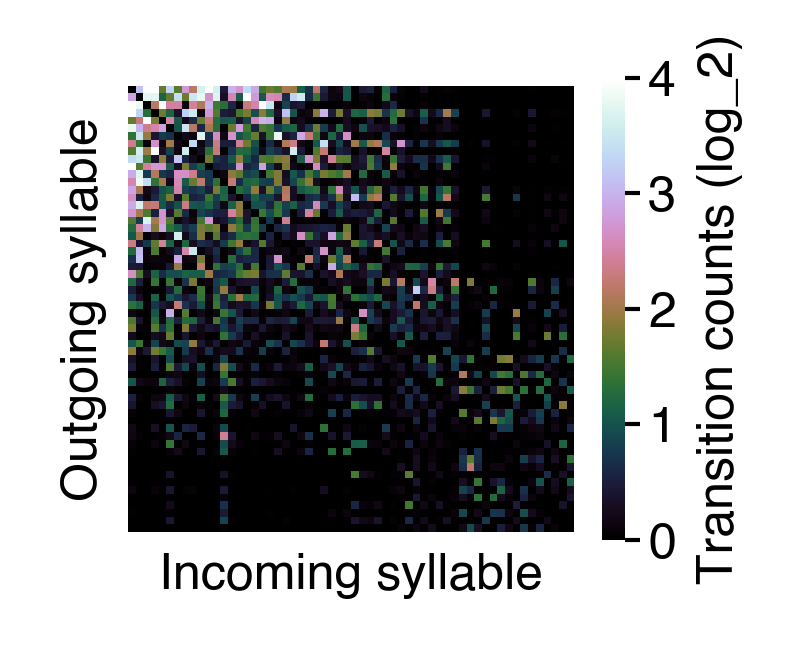

In [95]:
fig = figure(1.2, 1)
ax = sns.heatmap(
    np.log2(tm[usage_sort][:, usage_sort] + 1),
    vmax=4,
    cbar_kws=dict(label="Transition counts (log_2)"),
    cmap="cubehelix",
)
ax.set(
    aspect="equal",
    xticks=[],
    yticks=[],
    xlabel="Incoming syllable",
    ylabel="Outgoing syllable",
)
saver(fig, "total-transition-matrix-log-transformed");

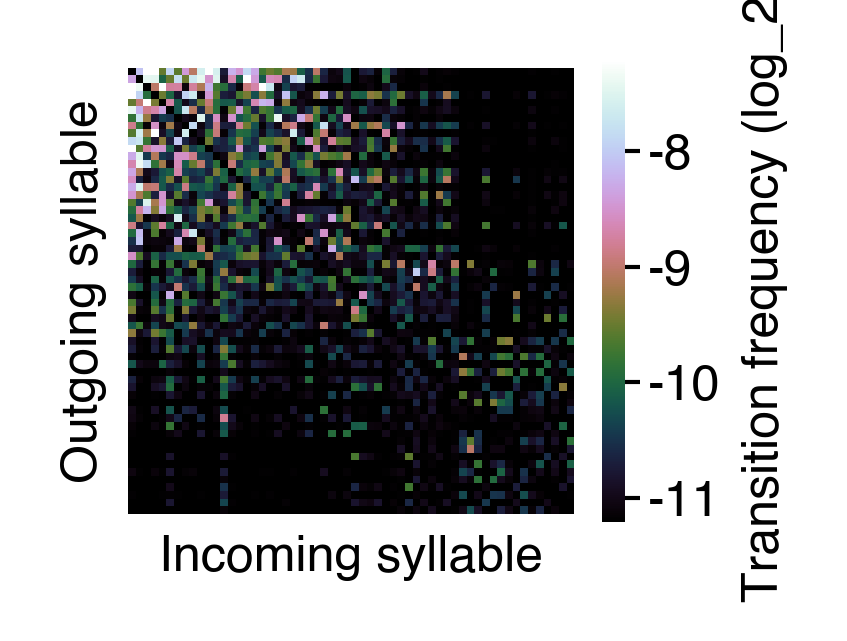

In [97]:
fig = figure(1.2, 1)
ax = sns.heatmap(
    np.log2(tm[usage_sort][:, usage_sort] + 1) - np.log2(tm.sum()),
    vmax=4 - np.log2(tm.sum()),
    cbar_kws=dict(label="Transition frequency (log_2)"),
    cmap="cubehelix",
)
ax.set(
    aspect="equal",
    xticks=[],
    yticks=[],
    xlabel="Incoming syllable",
    ylabel="Outgoing syllable",
)
saver(fig, "total-transition-matrix-log-transformed-frequency");

## Usage plots for individuals at different ages

In [143]:
ex = usage_df.loc[4].iloc[[0, 5, 10]]
out = ex.reset_index(level='mouse', drop=False).melt(id_vars='mouse')

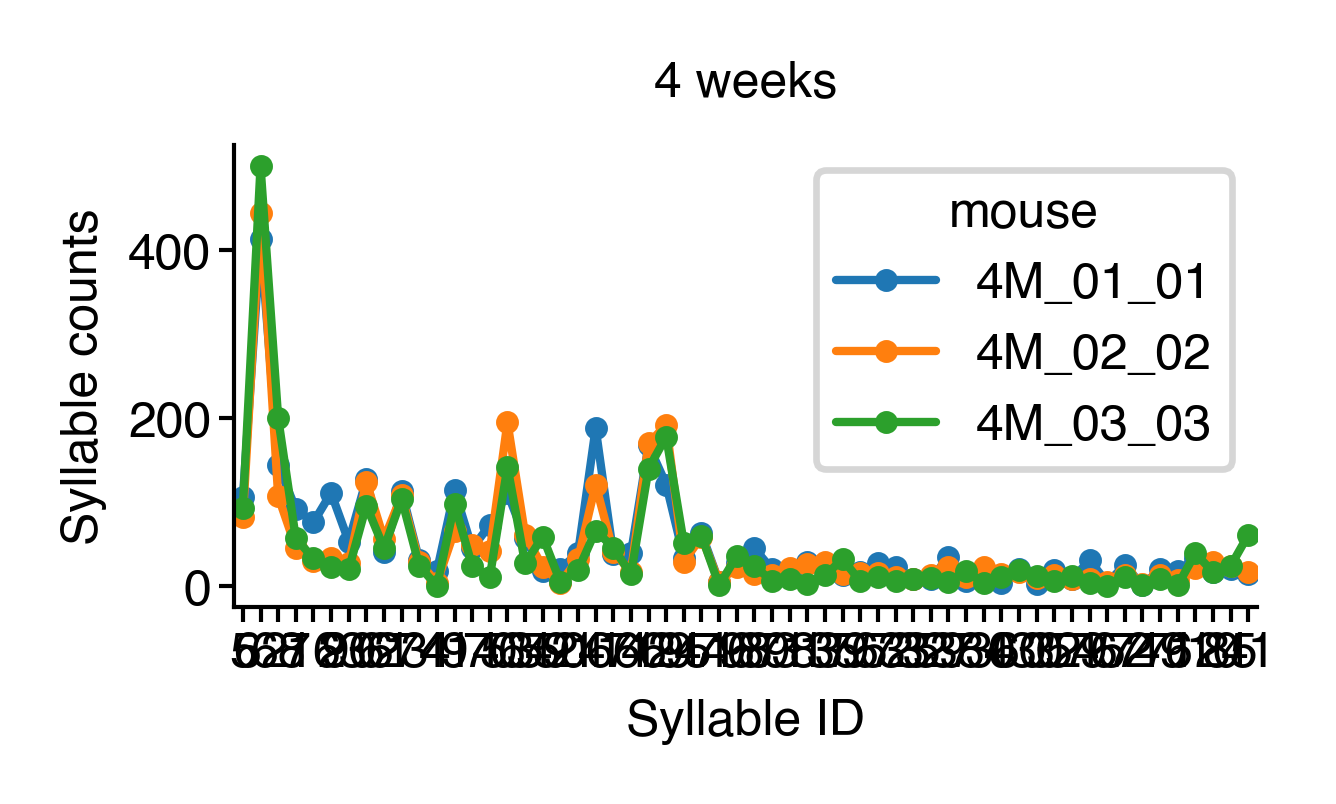

In [144]:
fig = figure(2.2, 1)
ax = sns.pointplot(data=out, x='syllables', y='value', hue='mouse', order=order, linewidth=1, markersize=2)
ax.set(xlabel="Syllable ID", ylabel="Syllable counts", title="4 weeks")
sns.despine()
saver(fig, "4wk-example-usage");

In [145]:
ex = usage_df.loc[12].iloc[[0, 5, 10]]
out = ex.reset_index(level='mouse', drop=False).melt(id_vars='mouse')

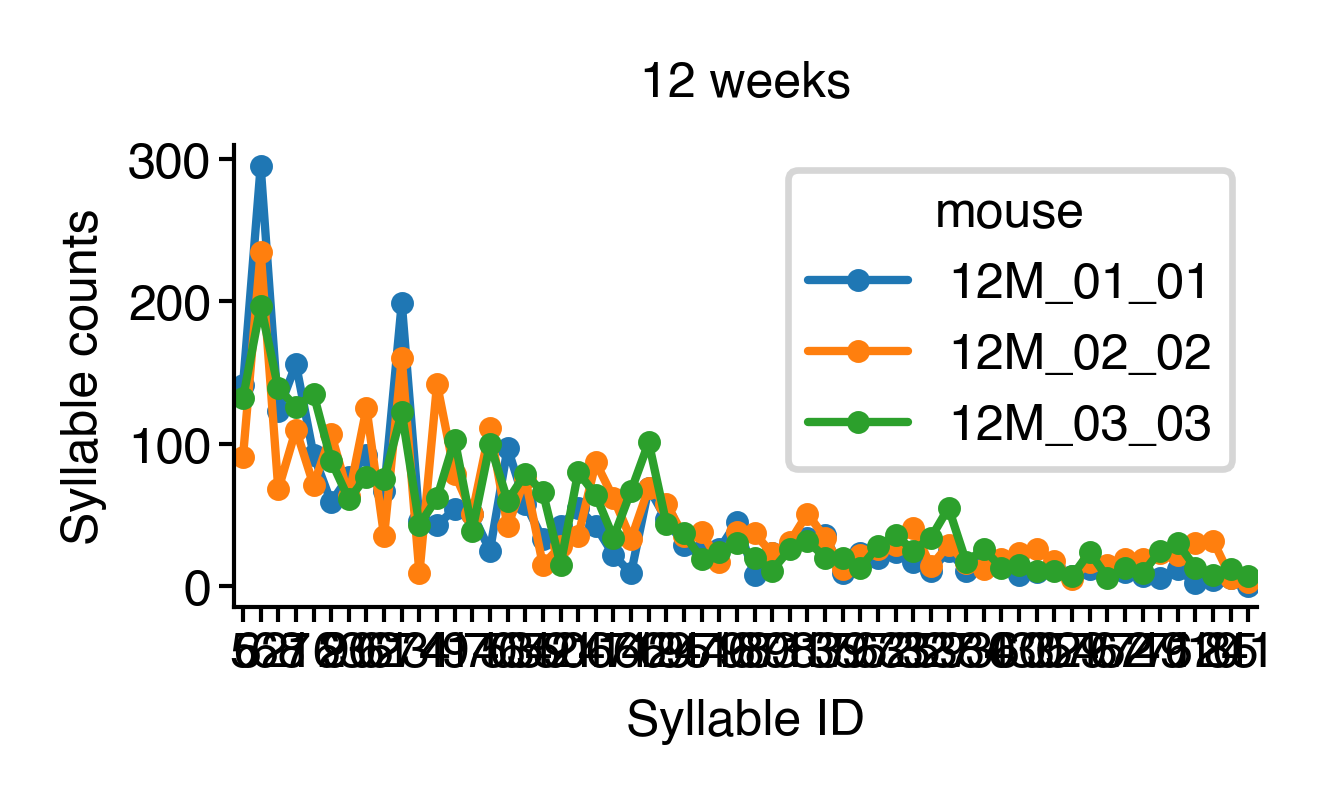

In [146]:
fig = figure(2.2, 1)
ax = sns.pointplot(data=out, x='syllables', y='value', hue='mouse', order=order, linewidth=1, markersize=2)
ax.set(xlabel="Syllable ID", ylabel="Syllable counts", title="12 weeks")
sns.despine()
saver(fig, "12wk-example-usage");

In [147]:
usage_df.index.get_level_values('age').unique()

Index([  4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,  52,  56,
        60,  64,  68,  72,  78,  80,  84,  90, 103],
      dtype='int64', name='age')

In [148]:
ex = usage_df.loc[40].iloc[[0, 5, 10]]
out = ex.reset_index(level='mouse', drop=False).melt(id_vars='mouse')

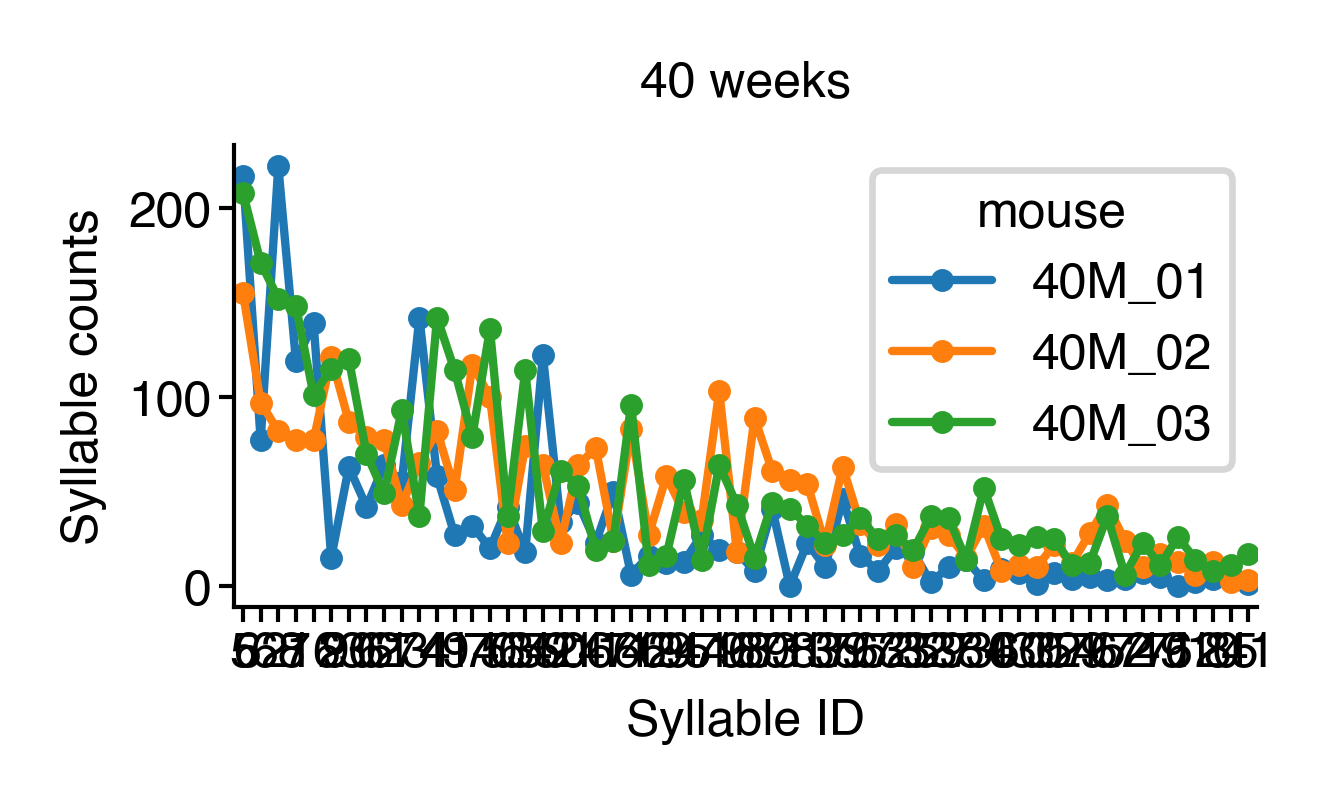

In [149]:
fig = figure(2.2, 1)
ax = sns.pointplot(data=out, x='syllables', y='value', hue='mouse', order=order, linewidth=1, markersize=2)
ax.set(xlabel="Syllable ID", ylabel="Syllable counts", title="40 weeks")
sns.despine()
saver(fig, "40wk-example-usage");

In [150]:
ex = usage_df.loc[80].iloc[[0, 6, 10]]
out = ex.reset_index(level='mouse', drop=False).melt(id_vars='mouse')

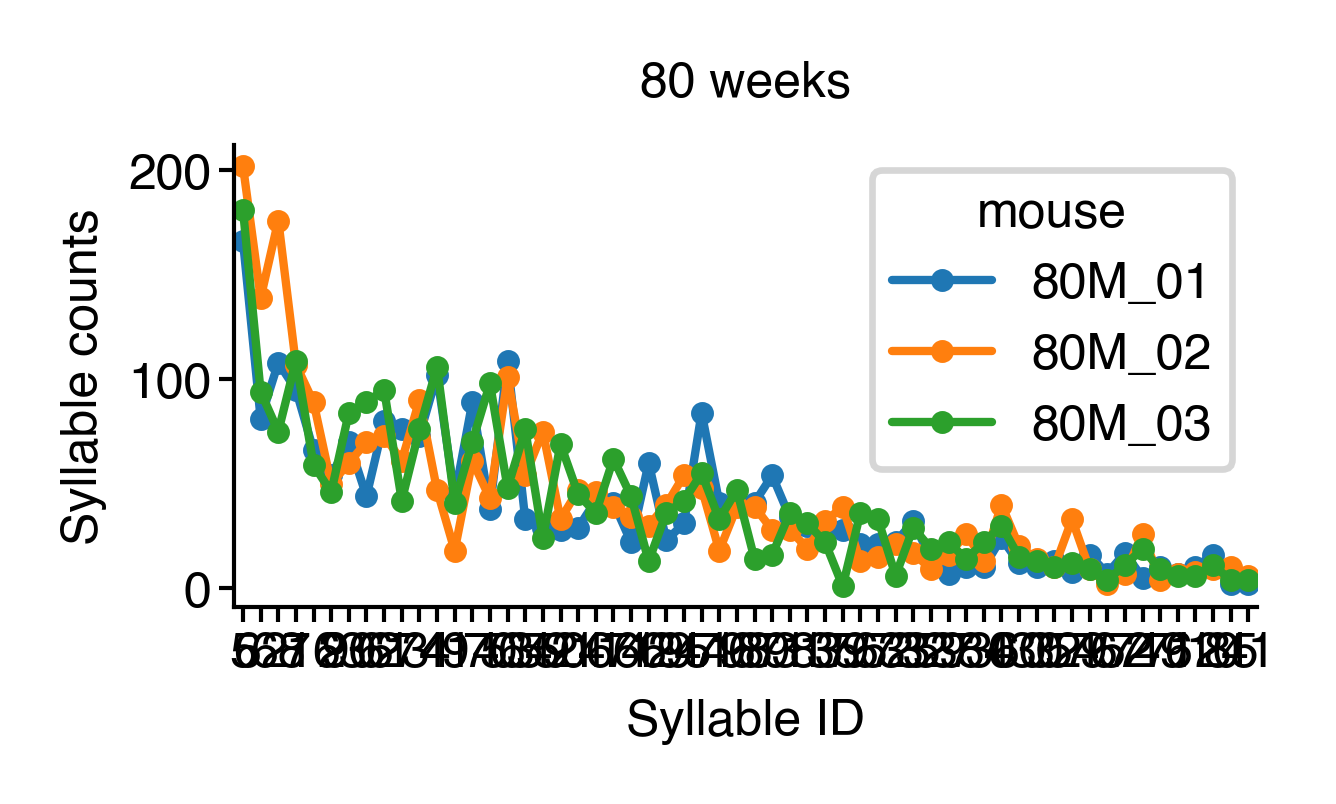

In [151]:
fig = figure(2.2, 1)
ax = sns.pointplot(data=out, x='syllables', y='value', hue='mouse', order=order, linewidth=1, markersize=2)
ax.set(xlabel="Syllable ID", ylabel="Syllable counts", title="80 weeks")
sns.despine()
saver(fig, "80wk-example-usage");

## Comparison of regression performances

## PCA correlation with age

In [4]:
norm_df = usage_df - usage_df.min()
norm_df = norm_df / norm_df.max()

In [5]:
scores = PCA(n_components=25).fit_transform(norm_df)

In [13]:
corrs = []
for i in range(15):
    corrs.append(
        pd.Series(scores[:, i]).corr(pd.Series(norm_df.index.get_level_values('age')), method='spearman')
    )

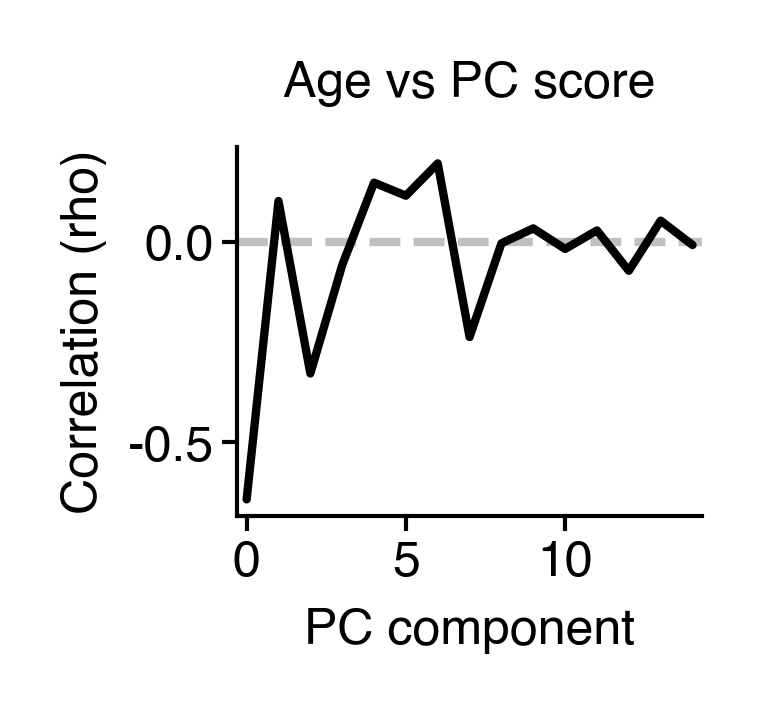

In [16]:
fig = figure(1, 0.8)
ax = fig.gca()
ax.plot(corrs, color='k')
ax.set(xlabel="PC component", ylabel="Correlation (rho)", title="Age vs PC score", xlim=(-0.3, 14.3))
ax.axhline(0, color='silver', ls='--', zorder=-1)
sns.despine()
saver(fig, "pca-correlated-with-age");